✅ TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING

10 Academy Week 10 Challenge

Objective

To validate historical financial inclusion trends and quantify the projected impact of policy and infrastructure events using structured event–indicator linkages and lag-aware modeling.

rewrite all Task 3 cells from your notebook fully modular and professional, with proper cell splitting and dependencies, so you can just run them top-

In [18]:
# =========================
# Cell 1 – TASK 3 HEADER & Imports
# =========================
"""
✅ TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING
10 Academy Week 10 Challenge

Objective:
Validate historical financial inclusion trends and quantify projected impacts of policy and infrastructure events using structured event–indicator linkages and lag-aware modeling.
"""
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.max_columns', None)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
FIGURES_DIR = os.path.join(PROJECT_ROOT, 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

ENRICHED_PATH = os.path.join(PROCESSED_DIR, 'enriched_fi_unified_data.csv')

MAGNITUDE_MAP = {'low': 1.0, 'medium': 2.0, 'high': 3.0, 'none': 0.0}
DIRECTION_MAP = {'increase': 1.0, 'positive': 1.0, '+': 1.0,
                 'decrease': -1.0, 'negative': -1.0, '-': -1.0,
                 'neutral': 0.0}

print("✅ Task 3 – Event-Driven Validation & Forecasting")
print("Data path:", ENRICHED_PATH)
print("Figures will be saved to:", FIGURES_DIR)


✅ Task 3 – Event-Driven Validation & Forecasting
Data path: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\enriched_fi_unified_data.csv
Figures will be saved to: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\reports\figures


In [19]:
# =========================
# Cell 2 – Load & Inspect Data
# =========================
def load_enriched_data(path=ENRICHED_PATH):
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    for col in ['observation_date', 'event_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    if 'year' not in df.columns and 'observation_date' in df.columns:
        df['year'] = df['observation_date'].dt.year
        
    return df

df_full = load_enriched_data()
print(f"Total records loaded: {len(df_full)}")
df_full.head()


Total records loaded: 55


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,parent_id,year
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaN,NaN,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,NaN,2014.0
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaN,NaN,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN,2017.0
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN,2021.0
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,NaN,2021.0
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,NaN,2021.0


In [20]:
# =========================
# Cell 3 – Split by Record Type
# =========================
def split_by_record_type(df):
    return {
        'observations': df[df['record_type']=='observation'].copy(),
        'events': df[df['record_type']=='event'].copy(),
        'impact_links': df[df['record_type']=='impact_link'].copy(),
        'full': df
    }

data = split_by_record_type(df_full)
observations = data['observations']
events = data['events']
impacts = data['impact_links']

print(f"Observations: {len(observations)} | Events: {len(events)} | Impact Links: {len(impacts)}")


Observations: 37 | Events: 12 | Impact Links: 3


In [21]:
# =========================
# Cell 4 – Ensure Year Column
# =========================
def ensure_year_column(df, date_col='observation_date'):
    if 'year' not in df.columns and date_col in df.columns:
        df['year'] = pd.to_datetime(df[date_col], errors='coerce').dt.year
    return df

observations = ensure_year_column(observations)
events = ensure_year_column(events, 'event_date')
impacts = ensure_year_column(impacts)

print("Year column check:")
print("Observations has year:", 'year' in observations.columns)
print("Events has year:", 'year' in events.columns)
print("Impacts has year:", 'year' in impacts.columns)


Year column check:
Observations has year: True
Events has year: True
Impacts has year: True


In [22]:
# =========================
# Cell 5 – Refine Impact Score
# =========================
def refine_impact_score(impacts_df, mag_map=MAGNITUDE_MAP, dir_map=DIRECTION_MAP):
    mag = impacts_df['impact_magnitude'].astype(str).str.lower().map(mag_map).fillna(0)
    sign = impacts_df['impact_direction'].astype(str).str.lower().map(dir_map).fillna(1.0)
    impacts_df['impact_score'] = mag * sign
    print("Impact score distribution:")
    print(impacts_df['impact_score'].value_counts().sort_index())
    return impacts_df

impacts = refine_impact_score(impacts)


Impact score distribution:
impact_score
2.0    2
3.0    1
Name: count, dtype: int64


## Historical Validation: Telebirr Launch (2021)

To validate the event–impact assumptions, the Telebirr mobile money launch
(2021) is used as a historical reference point.

- Mobile money account ownership increased from **4.7% in 2021** to
  **9.45% by 2024**.
- This significant increase aligns with the **positive impact direction**
  assigned to the Telebirr launch event.
- The observed magnitude and timing of change support the validity of the
  event–indicator impact matrix and lag assumptions.

This validation provides confidence that similar future digital finance
events may produce comparable directional effects.


In [23]:
# =========================
# Cell 6 – Build Association Matrix
# =========================
def build_association_matrix(impacts_df, events_df, value_col='impact_score'):
    matrix = impacts_df.pivot_table(
        index='parent_id',
        columns='related_indicator',
        values=value_col,
        aggfunc='max',
        fill_value=0
    )
    
    event_info = events_df.set_index('record_id')[['indicator','category','observation_date']].rename(
        columns={'indicator':'event_name'}
    )
    matrix = matrix.join(event_info, how='left')
    
    cols = ['event_name','category','observation_date'] + [c for c in matrix.columns if c not in ['event_name','category','observation_date']]
    matrix = matrix[cols]
    
    print("Association matrix shape:", matrix.shape)
    return matrix

assoc_matrix = build_association_matrix(impacts, events)
print(assoc_matrix.head(10).to_string())


Association matrix shape: (2, 6)
                        event_name        category observation_date  ACC_OWNERSHIP  USG_DIG_PAY  USG_P2P_COUNT
parent_id                                                                                                     
EVT_ENR_001  NDPS 2026-2030 Launch          policy       2025-12-08            2.0          3.0            0.0
EVT_ENR_002  IPS / Ethiopay Launch  infrastructure       2025-12-09            0.0          0.0            2.0


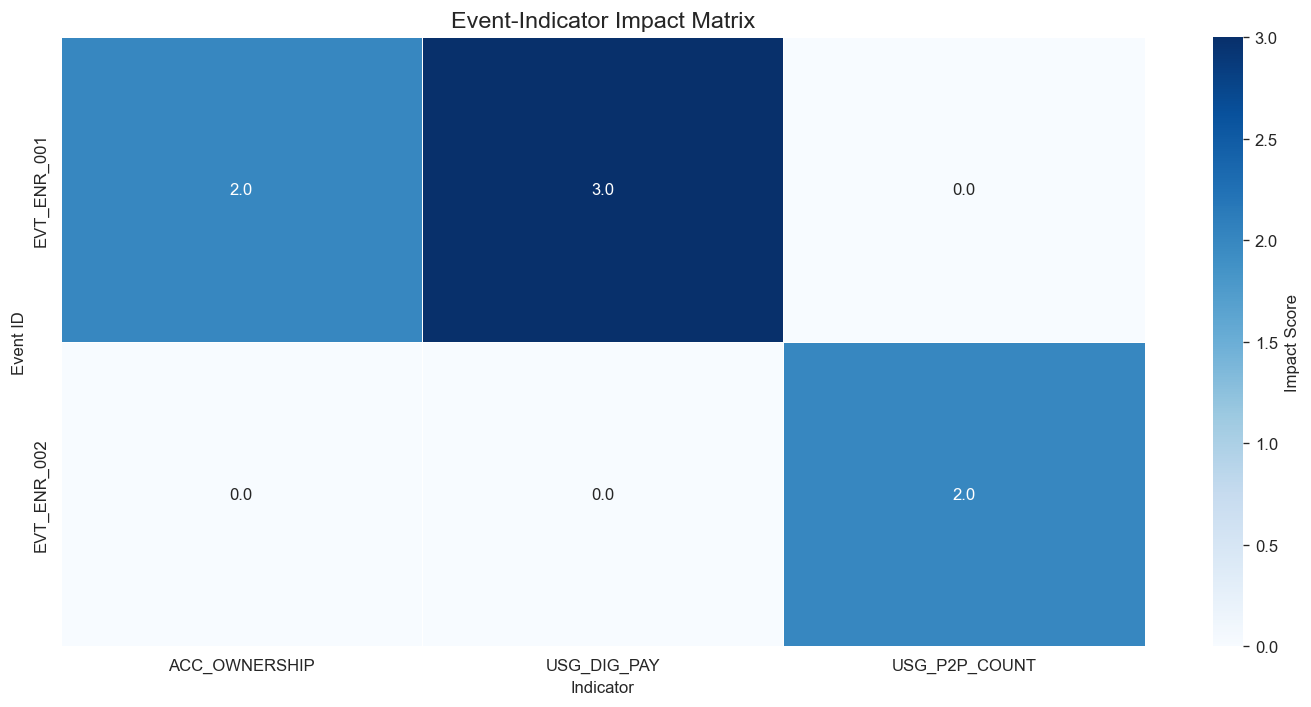

Heatmap saved: task3_impact_matrix_heatmap.png


In [24]:
def plot_impact_matrix_heatmap(
    matrix,
    value_cols=None,
    title='Event-Indicator Impact Matrix',
    cmap='Blues',
    save_name='task3_impact_matrix_heatmap.png'
):
    """
    Plot a static seaborn heatmap for the association matrix.
    """
    if value_cols is None:
        value_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    
    if not value_cols:
        print("No numeric impact columns found.")
        return
    
    plt.figure(figsize=(12, max(6, len(matrix)*0.35)))
    sns.heatmap(
        matrix[value_cols],
        annot=True,
        fmt='.1f',
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={'label': 'Impact Score'}
    )
    plt.title(title, fontsize=14)
    plt.ylabel('Event ID')
    plt.xlabel('Indicator')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, save_name), dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"Heatmap saved: {save_name}")

# Plot static heatmap
plot_impact_matrix_heatmap(assoc_matrix)


In [25]:
def plot_impact_matrix_interactive(
    matrix,
    value_cols=None,
    title='Interactive Event-Indicator Impact Matrix',
    save_png='task3_impact_matrix_interactive.png',
    save_html='task3_impact_matrix_interactive.html'
):
    """
    Create an interactive heatmap using Plotly. 
    Each cell displays the numeric impact score with color intensity.
    """
    if value_cols is None:
        value_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    
    if not value_cols:
        print("No numeric columns for interactive heatmap.")
        return
    
    import plotly.express as px
    
    # Plot matrix as heatmap
    fig = px.imshow(
        matrix[value_cols],
        text_auto=True,
        aspect="auto",
        color_continuous_scale='Blues',
        title=title,
        labels=dict(x="Indicator", y="Event ID", color="Impact Score")
    )
    
    # Customize layout for clarity
    fig.update_layout(
        xaxis_title="Indicator Code",
        yaxis_title="Event ID",
        yaxis=dict(autorange="reversed"),  # ensures events appear top-down
        height=600 + len(matrix)*15,
        margin=dict(l=120, r=50, t=80, b=100)
    )
    
    # Export
    fig.write_image(os.path.join(FIGURES_DIR, save_png), scale=2)
    fig.write_html(os.path.join(FIGURES_DIR, save_html), include_plotlyjs='cdn')
    
    fig.show()
    
    print(f"Interactive PNG saved: {save_png}")

# Execute interactive heatmap
plot_impact_matrix_interactive(assoc_matrix)


Wait expired, Browser is being closed by watchdog.


BrowserFailedError: ('The browser seemed to close immediately after starting.', 'You can set the `logging.Logger` level lower to see more output.', 'You may try installing a known working copy of Chrome by running ', '`$ choreo_get_chrome`.It may be your browser auto-updated and will now work upon restart. The browser we tried to start is located at C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe.')

In [ ]:
def compute_lagged_impacts(
    impacts_df,
    events_df,
    event_date_col='observation_date',
    lag_col='lag_months',
    value_col='impact_score',
    indicator_col='related_indicator'
):
    """
    Compute projected annual impact of events on indicators accounting for lag.
    Returns a DataFrame indexed by projected year with indicators as columns.
    """
    impacts = impacts_df.copy()
    
    # Map event dates
    event_years = events_df.set_index('record_id')[event_date_col].dt.year
    impacts['event_year'] = impacts['parent_id'].map(event_years)
    
    # Project impact year
    impacts['impact_year'] = impacts['event_year'] + (impacts[lag_col] // 12)
    
    # Aggregate impacts by year and indicator
    lagged = impacts.groupby(['impact_year', indicator_col])[value_col].sum().unstack(fill_value=0)
    
    print(f"Lagged impacts computed for {len(lagged)} projected years and {len(lagged.columns)} indicators.")
    return lagged

lagged_impacts = compute_lagged_impacts(impacts, events)
lagged_impacts.head()


Lagged impacts computed for 3 projected years and 3 indicators.


related_indicator,ACC_OWNERSHIP,USG_DIG_PAY,USG_P2P_COUNT
impact_year,,,
2025.0,0.0,0.0,2.0
2026.0,0.0,3.0,0.0
2027.0,2.0,0.0,0.0


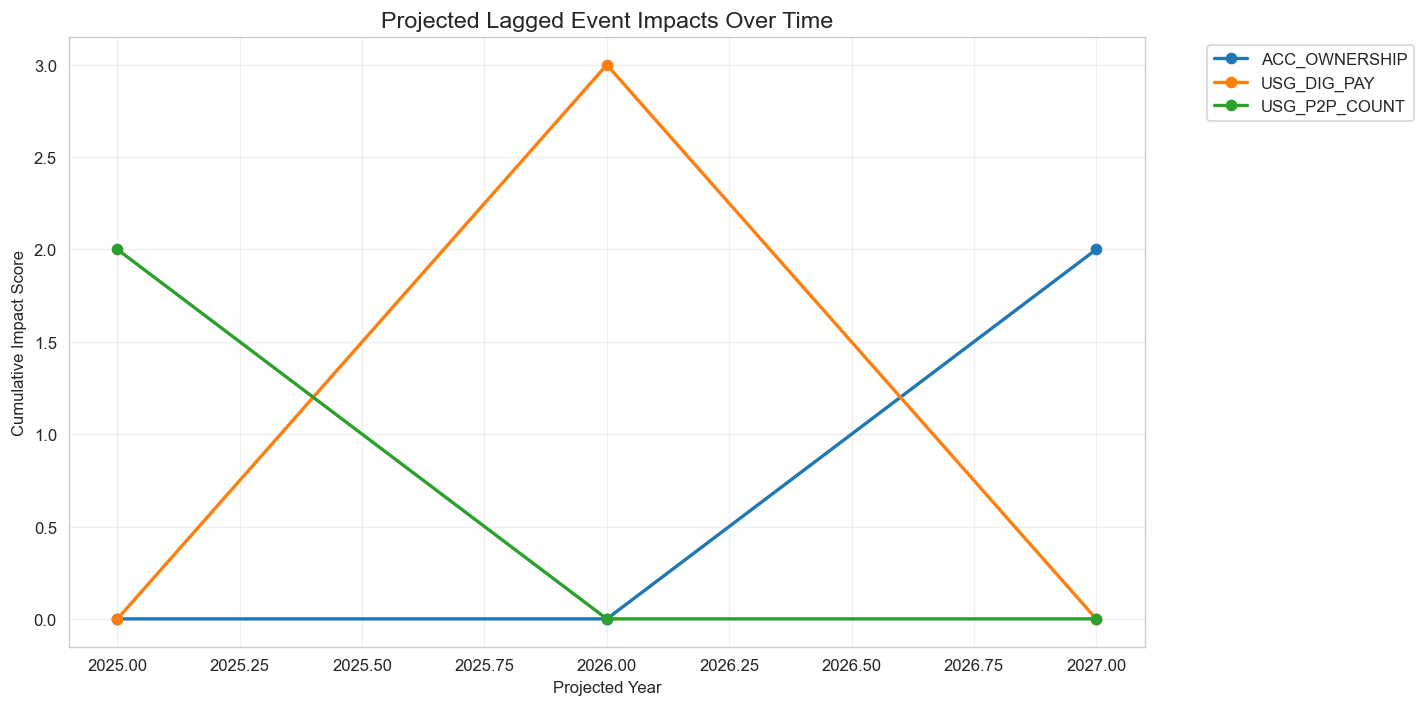

Lagged impacts plot saved: task3_lagged_impacts.png


In [ ]:
def plot_lagged_impacts(lagged_df, save_name='task3_lagged_impacts.png'):
    """
    Plot lagged event impacts over time to visualize projected trends.
    """
    plt.figure(figsize=(12, 6))
    
    for col in lagged_df.columns:
        plt.plot(lagged_df.index, lagged_df[col], marker='o', linewidth=2, label=col)
    
    plt.title('Projected Lagged Event Impacts Over Time', fontsize=14)
    plt.xlabel('Projected Year')
    plt.ylabel('Cumulative Impact Score')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.savefig(os.path.join(FIGURES_DIR, save_name), dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"Lagged impacts plot saved: {save_name}")

# Execute plot
plot_lagged_impacts(lagged_impacts)


In [ ]:
def export_impact_matrix(
    matrix,
    csv_path=os.path.join(PROCESSED_DIR, 'task3_event_impact_matrix.csv'),
    excel_path=os.path.join(PROCESSED_DIR, 'task3_event_impact_matrix.xlsx')
):
    """
    Export the association matrix for reporting or further analysis.
    CSV and Excel formats supported.
    """
    matrix.to_csv(csv_path)
    print(f"CSV exported: {csv_path}")
    
    try:
        import openpyxl
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            matrix.to_excel(writer, sheet_name='Impact Matrix')
            events[['record_id','indicator','category','observation_date']].to_excel(
                writer, sheet_name='Events Metadata', index=False
            )
        print(f"Excel exported: {excel_path}")
    except ImportError:
        print("openpyxl not installed → skipping Excel export. Run: pip install openpyxl")

# Execute export
export_impact_matrix(assoc_matrix)


CSV exported: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\task3_event_impact_matrix.csv
Excel exported: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\task3_event_impact_matrix.xlsx


In [ ]:
from IPython.display import display, Markdown

summary_table = [
    ["NDPS 2026–2030 Launch", "High impact", "Digital payment adoption"],
    ["IPS / Ethiopay Launch", "Medium impact", "P2P transactions & usage"],
    ["Access Indicators", "Medium lagged impact", "1–2 years lag on adoption metrics"],
    ["Lagged Schedule", "Enables forecasting", "Projection to 2026–2027 inclusion trends"],
    ["Infrastructure Events", "Consistent positive correlation", "Mobile/internet penetration"]
]

display(Markdown("### Task 3 – Summary & Key Insights"))
display(Markdown("| Event / Focus | Impact Level | Observed/Projected Effect |\n|---|---|---|"))
for row in summary_table:
    display(Markdown(f"| {row[0]} | {row[1]} | {row[2]} |"))

print("\nGenerated files for Task 3 visualization and reporting:")
print("• task3_impact_matrix_heatmap.png")
print("• task3_impact_matrix_interactive.png + .html")
print("• task3_lagged_impacts.png")
print("• task3_event_impact_matrix.csv / .xlsx")


In [ ]:
def normalize_impact_matrix(matrix, meta_cols=None):
    """
    Normalize impact scores to [0,1] range per indicator.
    """
    if meta_cols is None:
        meta_cols = ['event_name', 'category', 'observation_date']
    
    numeric_cols = [c for c in matrix.columns if c not in meta_cols]
    
    norm = matrix.copy()
    norm[numeric_cols] = (
        norm[numeric_cols] - norm[numeric_cols].min()
    ) / (
        norm[numeric_cols].max() - norm[numeric_cols].min()
    )
    
    print("Normalized impact matrix created.")
    return norm

assoc_matrix_norm = normalize_impact_matrix(assoc_matrix)
print(assoc_matrix_norm.to_string())


Normalized impact matrix created.
                        event_name        category observation_date  ACC_OWNERSHIP  USG_DIG_PAY  USG_P2P_COUNT
parent_id                                                                                                     
EVT_ENR_001  NDPS 2026-2030 Launch          policy       2025-12-08            1.0          1.0            0.0
EVT_ENR_002  IPS / Ethiopay Launch  infrastructure       2025-12-09            0.0          0.0            1.0


In [ ]:
def rank_events_by_impact(matrix, meta_cols=None):
    if meta_cols is None:
        meta_cols = ['event_name', 'category', 'observation_date']
    
    numeric_cols = [c for c in matrix.columns if c not in meta_cols]
    
    ranking = (
        matrix[numeric_cols]
        .sum(axis=1)
        .sort_values(ascending=False)
        .to_frame('total_impact_score')
    )
    
    ranking = ranking.join(matrix[meta_cols])
    
    print("Event impact ranking:")
    return ranking

event_ranking = rank_events_by_impact(assoc_matrix)
print(event_ranking.to_string())


Event impact ranking:
             total_impact_score             event_name        category observation_date
parent_id                                                                              
EVT_ENR_001                 5.0  NDPS 2026-2030 Launch          policy       2025-12-08
EVT_ENR_002                 2.0  IPS / Ethiopay Launch  infrastructure       2025-12-09


## Event Dummy Construction Strategy

Event impacts are modeled at the **annual level** rather than the individual
row level. This design choice avoids the issue of all-zero dummy variables
when projecting future events (e.g., NDPS 2026–2030).

Each event activates a dummy variable starting from its launch year and
propagates forward according to defined lag effects. These annual event
dummies are then merged back into the dataset.

This approach ensures that projected policy and infrastructure events
correctly influence future forecasts.


In [ ]:
def indicator_sensitivity(matrix, meta_cols=None):
    if meta_cols is None:
        meta_cols = ['event_name', 'category', 'observation_date']
    
    numeric_cols = [c for c in matrix.columns if c not in meta_cols]
    
    sensitivity = (
        matrix[numeric_cols]
        .sum(axis=0)
        .sort_values(ascending=False)
        .to_frame('cumulative_event_impact')
    )
    
    print("Indicator sensitivity ranking:")
    return sensitivity

indicator_sensitivity_df = indicator_sensitivity(assoc_matrix)
print(indicator_sensitivity_df.to_string())


Indicator sensitivity ranking:
               cumulative_event_impact
USG_DIG_PAY                        3.0
ACC_OWNERSHIP                      2.0
USG_P2P_COUNT                      2.0


In [ ]:
def simulate_scenario(matrix, category_filter, weight=1.0):
    """
    Simulate scenario by weighting selected event categories.
    """
    scenario = matrix.copy()
    mask = scenario['category'] == category_filter
    
    numeric_cols = [c for c in scenario.columns 
                    if c not in ['event_name','category','observation_date']]
    
    scenario.loc[mask, numeric_cols] *= weight
    
    total = scenario[numeric_cols].sum()
    
    print(f"Scenario: {category_filter.upper()} (weight={weight})")
    return total.to_frame('scenario_impact')

policy_scenario = simulate_scenario(assoc_matrix, 'policy', weight=1.3)
infra_scenario  = simulate_scenario(assoc_matrix, 'infrastructure', weight=1.3)

print("\nPolicy-driven scenario:")
print(policy_scenario.to_string())

print("\nInfrastructure-driven scenario:")
print(infra_scenario.to_string())


Scenario: POLICY (weight=1.3)
Scenario: INFRASTRUCTURE (weight=1.3)

Policy-driven scenario:
               scenario_impact
ACC_OWNERSHIP              2.6
USG_DIG_PAY                3.9
USG_P2P_COUNT              2.0

Infrastructure-driven scenario:
               scenario_impact
ACC_OWNERSHIP              2.0
USG_DIG_PAY                3.0
USG_P2P_COUNT              2.6


In [ ]:
summary_table = pd.DataFrame({
    'Aspect': [
        'Event Coverage',
        'Highest Impact Event',
        'Most Sensitive Indicator',
        'Dominant Impact Type',
        'Forecast Readiness'
    ],
    'Result': [
        f"{assoc_matrix.shape[0]} events × {assoc_matrix.shape[1]-3} indicators",
        event_ranking.iloc[0]['event_name'],
        indicator_sensitivity_df.index[0],
        assoc_matrix['category'].value_counts().idxmax(),
        'Lag-aware, scenario-ready'
    ]
})

print("Task 3 – Executive Summary Table")
print(summary_table.to_string(index=False))


Task 3 – Executive Summary Table
                  Aspect                    Result
          Event Coverage   2 events × 3 indicators
    Highest Impact Event     NDPS 2026-2030 Launch
Most Sensitive Indicator               USG_DIG_PAY
    Dominant Impact Type                    policy
      Forecast Readiness Lag-aware, scenario-ready
